## Nuclear Masses

In [6]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [17]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [18]:
def model(a_v,a_s,a_c,a_a,N,Z):
    A = N + Z
    return (a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)/(A**(1/3)) - a_a*((N-Z)**2)/A)/A

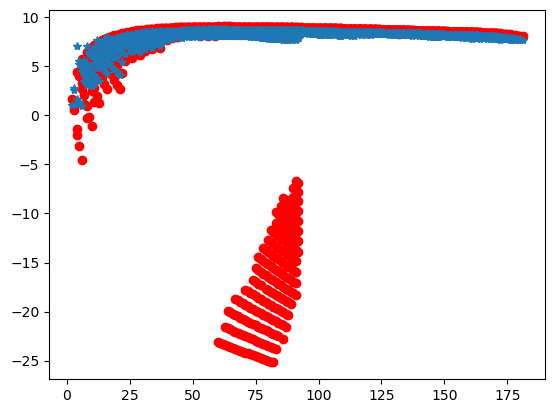

In [64]:
A = N + Z
n_points = 2000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_th = 16
a_s_th = 18
a_c_th = 0.7
a_a_th = 24

BE_th = model(a_v_th, a_s_th, a_c_th, a_a_th, N, Z)
plt.scatter(A[:n_points], BE_th[:n_points], color = 'red')

## EMCEE

In [78]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        -40 < a_a < 40
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params) + prior(params)

In [77]:
ndim = 4
nwalkers = 30

p0 = np.array([0, 0, 0, -40]) + np.random.rand(nwalkers, ndim) * np.array(
    [50, 50, 3, 40]
)

In [79]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 5000, progress=True)

100%|██████████| 5000/5000 [00:40<00:00, 122.75it/s]


State([[13.55754348 14.30734313  0.41800594 -5.13112858]
 [13.55754348 14.30734309  0.41800594 -5.13112851]
 [13.55754278 14.30734178  0.41800582 -5.13112692]
 [13.55754332 14.30734279  0.41800592 -5.13112826]
 [13.55754319 14.30734256  0.41800587 -5.13112723]
 [13.55754338 14.3073429   0.41800592 -5.13112823]
 [13.55754389 14.30734384  0.41800597 -5.13112888]
 [13.55754334 14.30734267  0.41800591 -5.13112794]
 [13.55754323 14.30734283  0.41800588 -5.1311278 ]
 [13.5575434  14.30734311  0.41800588 -5.13112786]
 [13.55754348 14.30734328  0.41800593 -5.13112832]
 [13.55754326 14.30734265  0.41800588 -5.13112754]
 [13.55754328 14.30734277  0.41800589 -5.13112757]
 [13.55754347 14.30734315  0.41800593 -5.13112845]
 [13.55754353 14.30734329  0.41800593 -5.1311282 ]
 [13.55754335 14.30734282  0.41800594 -5.13112861]
 [13.55754338 14.30734291  0.41800592 -5.13112822]
 [13.55754323 14.30734267  0.41800588 -5.13112755]
 [13.55754351 14.30734328  0.41800594 -5.13112878]
 [13.55754315 14.30734253

Text(0.5, 0, 'step number')

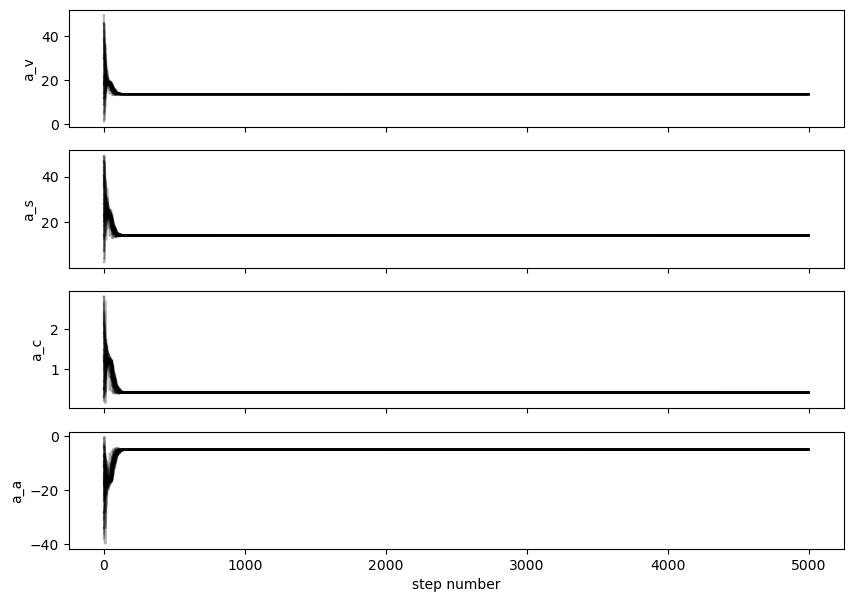

In [80]:
fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, np.float64(13.557542888966761)), (0.5, np.float64(13.557543370887448)), (0.975, np.float64(13.55754385406052))]
Quantiles:
[(0.025, np.float64(14.307342091484891)), (0.5, np.float64(14.30734297330731)), (0.975, np.float64(14.307343853279066))]
Quantiles:
[(0.025, np.float64(0.4180058222179585)), (0.5, np.float64(0.4180059101907029)), (0.975, np.float64(0.4180059987432261))]
Quantiles:
[(0.025, np.float64(-5.131129445154847)), (0.5, np.float64(-5.131128091496331)), (0.975, np.float64(-5.131126744090444))]


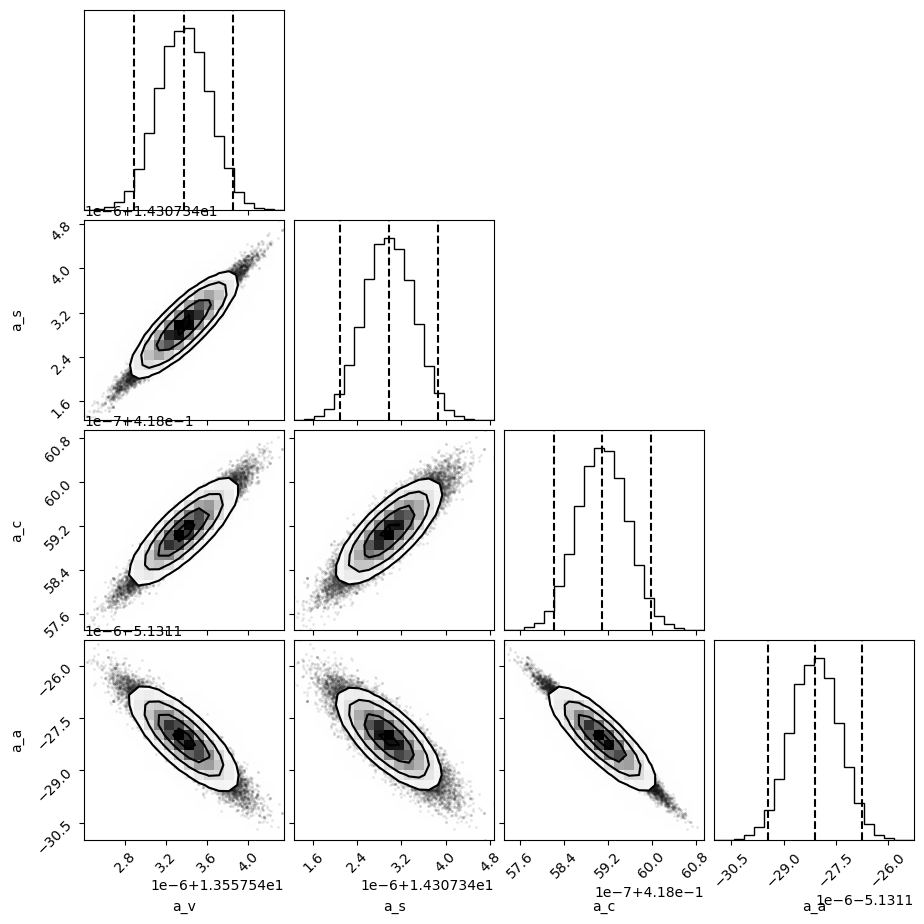

In [81]:
flat_samples = sampler.get_chain(discard=1000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a"], verbose= True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)

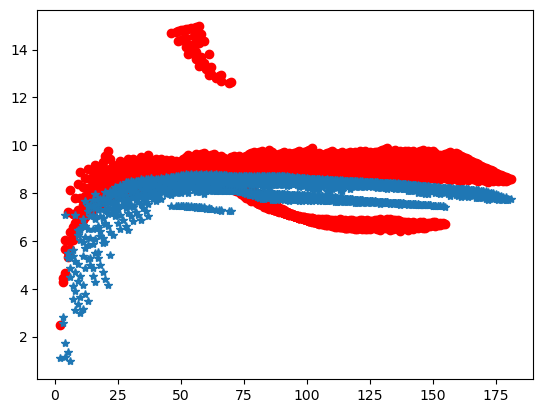

In [82]:
A = N + Z
n_points = 4000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_best = 13.6
a_s_best = 14
a_c_best = 0.4
a_a_best = -5

BE_best = model(a_v_best, a_s_best, a_c_best, a_a_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red')